# A Simple Implementation of GPT Model

In [1]:
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

In [21]:
@dataclass
class GPTConfig:
    block_size: int = 256
    vocab_size: int = 65 
    head_size: int = 16
    batch_size: int = 8
    n_layer: int = 4
    n_head: int = 4
    n_embd: int = 64
    dropout: float = 0.2
    bias: bool = False

In [22]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        # key, query, value projections for all heads, but in a batch
        self.k = nn.Linear(config.n_embd, config.head_size, bias=config.bias)
        self.q = nn.Linear(config.n_embd, config.head_size, bias=config.bias)
        self.v = nn.Linear(config.n_embd, config.head_size, bias=config.bias)

        # Causal attention mask
        self.register_buffer("tril", torch.tril(torch.ones(config.block_size, config.block_size)))
        
        

    def forward(self, x):
        B, T, C = x.size()
        
        k = self.k(x)
        v = self.v(x)
        q = self.q(x)

        att = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        att = F.softmax(att, dim=-1) # (B, T, T)
        out = att @ v
        
        return out

In [23]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.multi_head_attention = nn.ModuleList([CausalSelfAttention(config) for _ in range(config.n_head)])
        self.linear_projection = nn.Linear(config.head_size * config.n_head, config.n_embd)
        self.resid_dropout = nn.Dropout(config.dropout)


    def forward(self, x):
        attn_out = torch.cat([h(x) for h in self.multi_head_attention], dim=-1)
        attn_out = self.linear_projection(attn_out)
        attn_out = self.resid_dropout(attn_out)

        return attn_out

In [24]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )


    def forward(self, x):
        return self.net(x)
        

In [25]:
class AttentionBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, config):
        super().__init__()
        self.attention_block = MultiHeadAttention(config)
        self.feed_forward = FeedFoward(config)
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)


    def forward(self, x):
        x = x + self.attention_block(self.ln1(x))
        x = x + self.feed_forward(self.ln2(x))

        return x

In [26]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        # Tables of encodings
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding_table = nn.Embedding(config.block_size, config.n_embd)

        self.attentions_blocks = nn.Sequential(*[AttentionBlock(config) for _ in range(config.n_layer)])
        self.ln = nn.LayerNorm(config.n_embd) # final layer norm
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, x, targets=None):
        B, T = x.shape

        # x and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(x) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)


        x = self.attentions_blocks(x) # (B,T,C)
        x = self.ln(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

# Example Training

In [32]:
@dataclass
class TrainConfig:
    learning_rate: float = 3e-4
    eval_iters: int = 250
    max_iters: int = 500

In [33]:
with open('./data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

cars = sorted(list(set(text)))
vocab_size = len(cars)
print(f"Vocab size: {vocab_size}")

# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(cars)}
itos = {i:ch for i,ch in enumerate(cars)}

# encode and decoder for text to integer encodings
encode_text = lambda s: [stoi[c] for c in s]
decode_text = lambda l: ''.join([itos[i] for i in l])

# encode the tex
data = torch.tensor(encode_text(text), dtype=torch.long)

# split the data into train and test sets
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

Vocab size: 65


In [34]:
# TODO: fix the device assignment

class GPTTrain():
    def __init__(self, device, train_data, val_data):
        self.device = device
        self.train_data = train_data
        self.val_data = val_data
        self.model_config = GPTConfig()
        self.train_config = TrainConfig()
        self.model = GPT(self.model_config)
        self.model.to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.train_config.learning_rate)


    def _num_parameters(self):
        # print the number of parameters in the model
        print(sum(p.numel() for p in self.model.parameters())/1e6, 'MM parameters')


    def _get_batch(self, split):
        data = self.train_data if split == 'train' else self.val_data
        ix = torch.randint(len(data) - self.model_config.block_size, (self.model_config.batch_size,))
        x = torch.stack([data[i:i + self.model_config.block_size] for i in ix])
        y = torch.stack([data[i + 1:i + self.model_config.block_size + 1] for i in ix])
        return x, y


    @torch.no_grad()
    def _estimate_loss(self):
        out = {}
        self.model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(self.train_config.eval_iters)
            for k in range(self.train_config.eval_iters):
                X, Y = self._get_batch(split)
                logits, loss = self.model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        self.model.train()
        return out


    def generate(self, x, max_new_tokens=500):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = x[:, -self.model_config.block_size:]
            # get the predictions
            logits, loss = self.model(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            x = torch.cat((x, x_next), dim=1) # (B, T+1)
        return x


    def train(self):
        progress_bar = tqdm(range(self.train_config.max_iters), desc="Training")
        iter_losses = []
        for iter in progress_bar:

            # every once in a while evaluate the loss on train and val sets
            if (iter % self.train_config.eval_iters == 0 or
                iter == self.train_config.max_iters - 1):
                losses = self._estimate_loss()
                progress_bar.write(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

            # sample a batch of data
            x, y = self._get_batch('train')

            # evaluate the loss
            logits, loss = self.model(x, y)
            loss_item = loss.cpu().detach().item()
            progress_bar.set_postfix(loss=f"{loss_item:.4f}")
            iter_losses.append(loss_item)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()

        return iter_losses

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gpt_train = GPTTrain(device, train_data, val_data)
gpt_train._num_parameters()

losses = gpt_train.train()

0.224065 MM parameters


Training:   0%|          | 1/500 [00:31<4:18:37, 31.10s/it, loss=4.1701]

step 0: train loss 4.1703, val loss 4.1720


Training:  50%|█████     | 251/500 [01:44<38:58,  9.39s/it, loss=2.6839]

step 250: train loss 2.6473, val loss 2.6485


Training: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s, loss=2.4926]

step 499: train loss 2.5233, val loss 2.5197


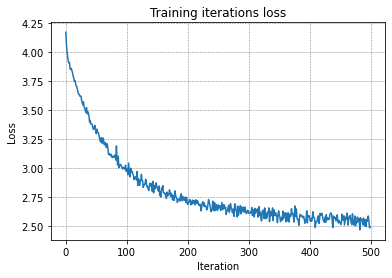

In [36]:
plt.plot(losses)
plt.title('Training iterations loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(color = 'gray', ls = '--', lw = 0.5)

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long).to(device)
print(decode_text(gpt_train.generate(context, max_new_tokens=500)[0].tolist()))


APungteidts, ay atre sno.af f houit s.


BERIHENCI


Kemenig mer sere,
Y's say domyon BTAque mha
Meliapinthiy ISSh king thoree fpl o tha; t ienctl, ceaicharono INlle aesanse

PIK:
-li? be iseROSe,

TII.
st'dr fue ces, HENw thy, oun gurd kee t ann s saphatkethas ISindiaiweay w, th f, t f m
Me Talisi s f HEUCallf ay&: po s:
Wy ;


were ms:
Whathed -
Askifinhbris w s, youre myir,
t tenoveawinod ow d s amel' m hov n I I shindy ke Yoprhersowis
YAne s tt ce, me, andeto h t thersentsGal Kco and, troll.
